# Sentiment Analyzer - Modeling
- Load in created features as well as original reviews and review meta data
- Build from-scratch model with multi class logistic regression, random forest, etc
- Compare results with state-of-the art pre-trained neural net like Distilhubert
- Target - Correctly predict sentiment of course reviews

## Imports and Data Prep

In [1]:
!pip install -q langdetect transformers xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import math
import re
import itertools
from langdetect import detect
import warnings
from tqdm import tqdm
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Import Coursera Data Set w/ Sentiment Features
- Has been filtered for gibberish
- Prep the data for predicting sentiment and summarizing
- Compare against transformers
- **NOTE:** For now, we'll limit to english words, as the transformer models that handle multiple languages have to be fine tuned for sentiment and very computationally intensive to fine-tune/run/download.

In [3]:
train_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/clean_sentiment_data/sentiment_train_clean.pkl')
val_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/clean_sentiment_data/sentiment_val_clean.pkl')
test_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/clean_sentiment_data/sentiment_test_clean.pkl')

- **Sample Size:** When using the transformers, we need to use a fraction of the entries to avoid super long training times and overloading memory. Sample size still will be on the order 10^4 so should be fine.
- **Languages:** Up to this point our analysis has been multi-language, but with fine tuning tranformer models, xlm-roberta-base is so large it presented issues with training. Additionally, many of the transformer models fine tuned for sentiment analysis (so we could get an out of the box comparison) didn't have many of the languages we needed. English will suffice for now. Additionaly, when sampling, VERY few of the entries are non english anyway.

In [4]:
print(train_df[train_df['sentiment'] == 1].review.iloc[0])

The first three weeks are good, a lot of good content, but he (despite trying) has trouble fitting all the methodologies together in one single framework that is actionable. 4th week is an absolute waste of time.Ideally, to improve the course, the author should give a concise overall picture, concatenating ideas, connecting them with a timeline of the PM's role throughout the product's life cycle/challenges.It seems to me that the course lacks an overarching view of the whole process. At the same time, the author goes through all the views, methodologies, and prisms of what it is to be a PM, he does not make those views compatible, which makes the course lack pragmatism, despite being a good introduction.


In [5]:
#train_df = train_df.sample(frac=0.50)
#val_df = val_df.sample(frac=0.50)
#test_df = test_df.sample(frac=0.50)

# Keep only positive and negative, toss neutral
#train_df = train_df[train_df['sentiment'] != 1]
#val_df = val_df[val_df['sentiment'] != 1]
#test_df = test_df[test_df['sentiment'] != 1]

# Try re labeling neutral as negative
train_df['sentiment'] = (train_df['sentiment'] == 2).astype(int)
val_df['sentiment'] = (val_df['sentiment'] == 2).astype(int)
test_df['sentiment'] = (test_df['sentiment'] == 2).astype(int)

# Filter only english for now
train_df = train_df[train_df['language'] == 'en']
val_df = val_df[val_df['language'] == 'en']
test_df = test_df[test_df['language'] == 'en']

# Get ratio of classes for XGBoost later
scale_pos_weight = train_df.sentiment.value_counts().values[1]/train_df.sentiment.value_counts().values[0]
'''
# Create balanced set for training
min_count = train_df['sentiment'].value_counts().min()
# Sample min_count rows from each class
train_df = (
    train_df.groupby('sentiment')
    .sample(n=min_count, random_state=42)  # random_state for reproducibility
    .reset_index(drop=True)
)
# Create balanced set for training
min_count = val_df['sentiment'].value_counts().min()
# Sample min_count rows from each class
val_df = (
    val_df.groupby('sentiment')
    .sample(n=min_count, random_state=42)  # random_state for reproducibility
    .reset_index(drop=True)
)
# Create balanced set for training
min_count = test_df['sentiment'].value_counts().min()
# Sample min_count rows from each class
test_df = (
    test_df.groupby('sentiment')
    .sample(n=min_count, random_state=42)  # random_state for reproducibility
    .reset_index(drop=True)
)
'''

"\n# Create balanced set for training\nmin_count = train_df['sentiment'].value_counts().min()\n# Sample min_count rows from each class\ntrain_df = (\n    train_df.groupby('sentiment')\n    .sample(n=min_count, random_state=42)  # random_state for reproducibility\n    .reset_index(drop=True)\n)\n# Create balanced set for training\nmin_count = val_df['sentiment'].value_counts().min()\n# Sample min_count rows from each class\nval_df = (\n    val_df.groupby('sentiment')\n    .sample(n=min_count, random_state=42)  # random_state for reproducibility\n    .reset_index(drop=True)\n)\n# Create balanced set for training\nmin_count = test_df['sentiment'].value_counts().min()\n# Sample min_count rows from each class\ntest_df = (\n    test_df.groupby('sentiment')\n    .sample(n=min_count, random_state=42)  # random_state for reproducibility\n    .reset_index(drop=True)\n)\n"

Note that sentiment has 3 values: 0, 1, and 2 with 0 being overtly negative, 1 being roughly neutral, and 2 being positive.

In [6]:
print(train_df.sentiment.value_counts())

sentiment
1    223414
0     14679
Name: count, dtype: int64


### Load in Coursera Data w/ Features

In [7]:
y_train = train_df['sentiment']
X_train = train_df.drop(columns=['sentiment'])

y_val = val_df['sentiment']
X_val = val_df.drop(columns=['sentiment'])

y_test = test_df['sentiment']
X_test = test_df.drop(columns=['sentiment'])

#### Features summary
- **Text Sentiment Indicators:** 'pos_word_count', 'neg_word_count', 'negated_pos_count', 'negated_neg_count' → Directly indicate sentiment
- **Polarity & Emotion Indicators:** 'polarity_score' → Strong single-value sentiment measure,'exclamation_count', 'uppercase_ratio' → Help capture enthusiasm or intensity

- **Text Complexity & Structure:** 'word_count', 'n_chars', 'avg_word_length' → Longer reviews tend to be more meaningful, 'max_repeated', 'punct_ratio' → Helps detect exaggeration/emphasis

- **Semantic & Statistical Features:** 'cosine_to_centroid' → Measures how much a review differs from a "typical" review, 'anomaly_score' → May help identify extreme sentiment outliers

In [8]:
sentiment_features = ['pos_word_count', 'neg_word_count', 'polarity_score', 
                      'exclamation_count','word_count', 'n_chars', 'avg_word_length',
                      'max_repeated','punct_ratio', 'cosine_to_centroid','anomaly_score']
X_train = X_train[sentiment_features]
X_val = X_val[sentiment_features]
X_test = X_test[sentiment_features]

### Sentiment Feature Selection

Feature Importance (All Features):
|    | Feature            |   Importance |
|---:|:-------------------|-------------:|
|  2 | polarity_score     |   0.512356   |
|  1 | neg_word_count     |   0.222868   |
|  0 | pos_word_count     |   0.111899   |
|  4 | word_count         |   0.0539062  |
|  5 | n_chars            |   0.0410727  |
|  3 | exclamation_count  |   0.0221338  |
| 10 | anomaly_score      |   0.0120341  |
|  9 | cosine_to_centroid |   0.00857156 |
|  6 | avg_word_length    |   0.00811492 |
|  7 | max_repeated       |   0.00425447 |
|  8 | punct_ratio        |   0.00278983 |


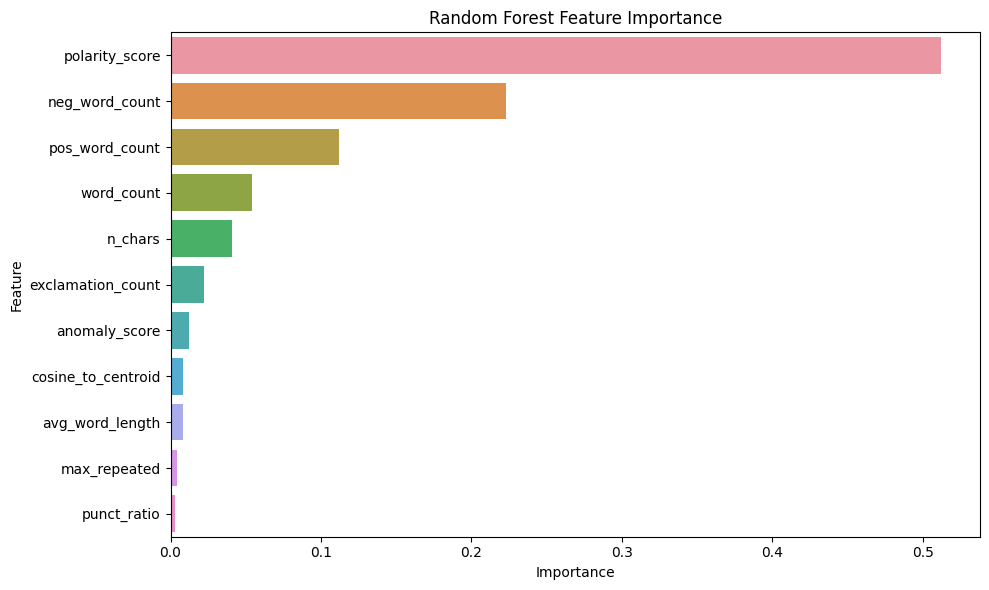

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_sentiment_model = RandomForestClassifier(max_depth= 5, n_estimators= 50)
rf_sentiment_model.fit(X_train, y_train)

# Feature importance
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_sentiment_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance (All Features):")
print(importances.to_markdown())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Random Forest Feature Importance')
plt.savefig('sentiment_rf_feature_importance.png')
plt.tight_layout()
plt.show()

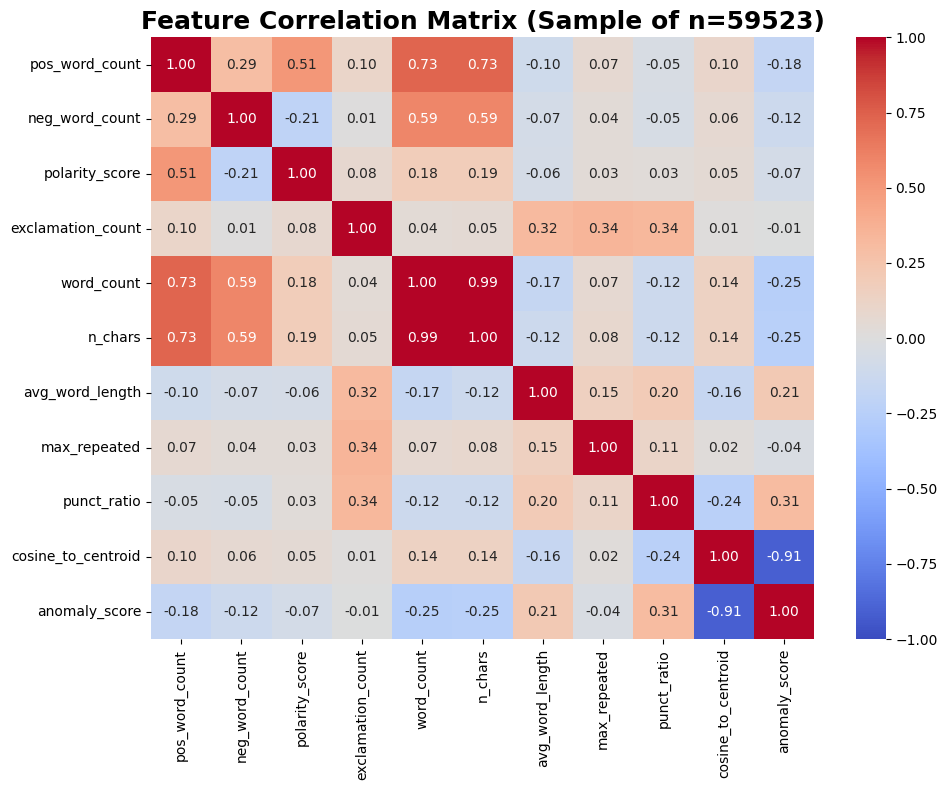

In [10]:
# Plot correlations between variables
corr = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title(f'Feature Correlation Matrix (Sample of n={int(0.25*len(X_train))})', size=18, fontweight='bold')
plt.tight_layout()
plt.savefig('sentiment_feature_corrs.png')
plt.show()

Given that polarity is linearly dependent upon pos_word_count and neg_word_count, we'll eliminate those. We'll also keep anomaly score but not cosine to centroid. We'll also keep word count but not n_chars. We'll cut max_repeated since it doesn't seem to matter at all. So features will be:
1. Polarity Score
2. Exclamation Count
3. Word Count
4. Avg Word Length
5. Punct Ratio
5. Anomaly Score

In [11]:
sentiment_features = ['polarity_score', 'exclamation_count','word_count', 
                      'avg_word_length','punct_ratio', 'anomaly_score']
X_train = X_train[sentiment_features]
X_val = X_val[sentiment_features]
X_test = X_test[sentiment_features]

## Classical ML Feature Based Sentiment Model
- Below, we take a feature based approach to predicitng sentiment of reviews using classical ML techniques
- **Baseline:** Our baseline model will be predicting the review is positive, as the vast majority of the original coursera ratings were 5/5.

In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [13]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, classification_report
from tabulate import tabulate
import random

# use similar set of different parameters for tuning as in gibberish model
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "params": {"C": [0.01, 0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced'),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]}
    },
    "XGBoost Classifer": {
        "model": XGBClassifier(scale_pos_weight=scale_pos_weight),
        "params": {"n_estimators": [50, 100, 200], 'max_depth': [3,5,7], "learning_rate": [0.01, 0.1, 0.2]}
    }
}

results = []
for name, info in models.items():
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(info["model"], info["params"], scoring='f1', cv=skf, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Baseline Prediction: Always Predicting 2
    y_pred_baseline = [1] * len(y_val)
    #y_pred_baseline = [random.randint(0, 2) for _ in range(len(y_val))]
    #y_pred_baseline = [random.choice([0,1]) for _ in range(len(y_val))]
    
    # Compute Metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="weighted")
    precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_val, y_pred, average="weighted", zero_division=0)
    
    accuracy_baseline = accuracy_score(y_val, y_pred_baseline)
    f1_baseline = f1_score(y_val, y_pred_baseline, average="weighted")
    precision_baseline = precision_score(y_val, y_pred_baseline, average="weighted", zero_division=0)
    recall_baseline = recall_score(y_val, y_pred_baseline, average="weighted", zero_division=0)


    results.append([name, accuracy, f1, precision, recall, grid_search.best_params_])

# 🔹 Create Markdown Table
results.append(["Baseline (Always Positive)", accuracy_baseline, f1_baseline, precision_baseline, recall_baseline, "N/A"])
headers = ["Model", "Accuracy", "F1 Score", "Precision", "Recall", "Best Hyperparameters"]
table = tabulate(results, headers=headers, tablefmt="github")

print(table)

filename = 'sentiment_model_classical_features.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

| Model                      |   Accuracy |   F1 Score |   Precision |   Recall | Best Hyperparameters                                        |
|----------------------------|------------|------------|-------------|----------|-------------------------------------------------------------|
| Logistic Regression        |   0.791821 |   0.842668 |    0.929867 | 0.791821 | {'C': 1}                                                    |
| Random Forest              |   0.959304 |   0.953962 |    0.954645 | 0.959304 | {'max_depth': None, 'n_estimators': 200}                    |
| XGBoost Classifer          |   0.827681 |   0.867041 |    0.934121 | 0.827681 | {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200} |
| Baseline (Always Positive) |   0.939662 |   0.910431 |    0.882964 | 0.939662 | N/A                                                         |


| Model                      |   Accuracy |   F1 Score |   Precision |   Recall | Best Hyperparameters                         |
|----------------------------|------------|------------|-------------|----------|----------------------------------------------|
| Logistic Regression        |   0.845395 |   0.878164 |    0.934224 | 0.845395 | {'C': 0.01}                                  |
| Random Forest              |   0.947368 |   0.932648 |    0.940468 | 0.947368 | {'max_depth': None, 'n_estimators': 200}     |
| Gradient Boosting          |   0.947368 |   0.932648 |    0.940468 | 0.947368 | {'learning_rate': 0.01, 'n_estimators': 200} |
| Baseline (Always Positive) |   0.9375   |   0.907258 |    0.878906 | 0.9375   | N/A                                          |

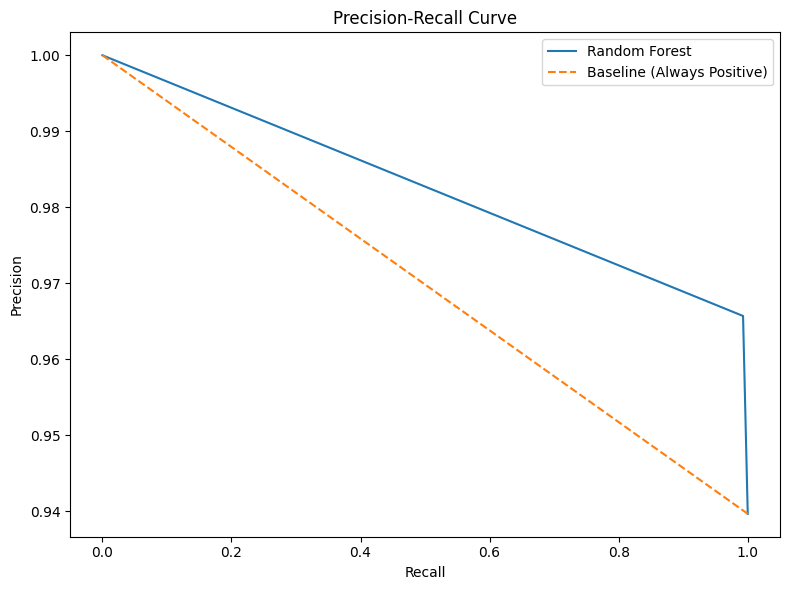

In [14]:
# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))

# Grab the best model
plot_model = RandomForestClassifier(max_depth= None, n_estimators= 100, class_weight='balanced')
plot_model.fit(X_train, y_train)
y_pred_plot = plot_model.predict(X_val)

precision_model, recall_model, _ = precision_recall_curve(y_val, y_pred_plot, pos_label=1)
plt.plot(recall_model, precision_model, label="Random Forest")

precision_baseline, recall_baseline, _ = precision_recall_curve(y_val, y_pred_baseline, pos_label=1)
plt.plot(recall_baseline, precision_baseline, linestyle="--", label="Baseline (Always Positive)")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.savefig('prc_sentiment.png')
plt.show()


## Out of Box Transformer Model

In [15]:
#from transformers import pipeline, XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Get pretrained multi langugage sentiment model
#model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
#tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
#model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=5)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) 

sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Function to run pipeline on dataframe
def get_predictions(reviews):
    predictions = sentiment_pipeline(reviews, truncation=True, padding=True, max_length=512)
    return [int(pred['label'].split("_")[-1]) for pred in predictions]  # Extract numerical sentiment labels

# Get predictions
y_pred = get_predictions(val_df['review'].tolist())

# Grab accuracy and f1
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
precision = precision_score(y_val, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_val, y_pred, average="weighted", zero_division=0)

# Make nice markdown table for comparing
table = [["Distilbert-base-uncased", accuracy, f1, precision, recall]]
print(tabulate(table, headers=["Model", "Accuracy", "F1 Score", "Precision", "Recall"], tablefmt="github"))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


| Model                   |   Accuracy |   F1 Score |   Precision |   Recall |
|-------------------------|------------|------------|-------------|----------|
| Distilbert-base-uncased |   0.061245 | 0.00887508 |    0.857876 | 0.061245 |


## Fine-tuned Neural Network Text Based Sentiment Model
- Take a pre-trained model from HuggingFace transformers
- Fine tune using our training set
- Use HuggingFace trainer API - https://huggingface.co/learn/nlp-course/en/chapter3/3?fw=pt

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-23d38412371a>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.125100,0.234574,0.942818,0.930678,0.928577,0.942818
2,0.111700,0.119303,0.962897,0.959677,0.959309,0.962897
3,0.093100,0.122711,0.964240,0.961528,0.961052,0.964240
4,0.084600,0.136498,0.965315,0.963789,0.963047,0.965315
5,0.077000,0.137618,0.966523,0.965072,0.964394,0.966523


| Model                   |   Accuracy |   F1 Score |
|-------------------------|------------|------------|
| distilbert-base-uncased |   0.962897 |   0.959677 |


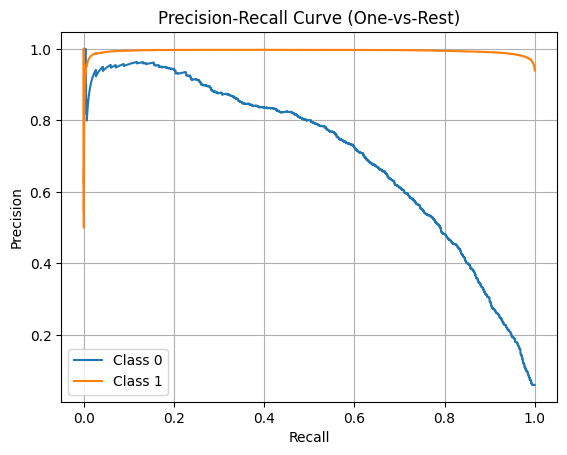

('./fine_tuned_distilbert-base-uncased/tokenizer_config.json',
 './fine_tuned_distilbert-base-uncased/special_tokens_map.json',
 './fine_tuned_distilbert-base-uncased/vocab.txt',
 './fine_tuned_distilbert-base-uncased/added_tokens.json',
 './fine_tuned_distilbert-base-uncased/tokenizer.json')

In [16]:
import torch
#from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

X_train_bert = train_df['review']
y_train_bert = y_train

X_val_bert = val_df['review']
y_val_bert = y_val

X_test_bert = test_df['review']
y_test_bert = y_test

# load multi language tokenizer and sequence classification model
#tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-small")
#model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-small", num_labels=3)

# Otherwise, re grab the one from above
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) 

def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=512)

train_encodings = tokenize_function(X_train_bert.tolist())
val_encodings = tokenize_function(X_val_bert.tolist())

# create Hugging Face Dataset so we can use huggingface trainer api
train_dataset = Dataset.from_dict({"input_ids": train_encodings['input_ids'], "attention_mask": train_encodings['attention_mask'], "labels": y_train.tolist()})
test_dataset = Dataset.from_dict({"input_ids": val_encodings['input_ids'], "attention_mask": val_encodings['attention_mask'], "labels": y_val.tolist()})

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_dir="./logs",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

trainer.train()

# Evaluation step
results = trainer.evaluate()
bert_accuracy = results['eval_accuracy']
bert_f1 = results['eval_f1']

# print results to 
table = [[model_name, bert_accuracy, bert_f1]]
print(tabulate(table, headers=["Model", "Accuracy", "F1 Score"], tablefmt="github"))

# Get predictions for plotting PR curve
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
preds = np.argmax(probs, axis=1)

# Plot Precision-Recall curve for each class
num_classes = probs.shape[1]
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(labels == i, probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()

model.save_pretrained(f"./fine_tuned_{model_name}")
tokenizer.save_pretrained(f"./fine_tuned_{model_name}")